# Humpback Whale Identifaction

In [71]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns

%matplotlib inline

In [21]:
train_df = pd.read_csv('Datas/train.csv')
train_df.head()

,Image,Id
0,00022e1a.jpg,w_e15442c
1,000466c4.jpg,w_1287fbc
2,00087b01.jpg,w_da2efe0
3,001296d5.jpg,w_19e5482
4,0014cfdf.jpg,w_f22f3e3


In [86]:
train_df['Id'] = train_df['Id'].astype('category')
train_df['Id'].value_counts().head()

new_whale    810
w_1287fbc     34
w_98baff9     27
w_7554f44     26
w_1eafe46     23
Name: Id, dtype: int64

In [51]:
num_categories = len(train_df['Id'].unique())
     
print(f'Number of categories: {num_categories}')

Number of categories: 4251


In [87]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9850 entries, 0 to 9849
Data columns (total 2 columns):
Image    9850 non-null object
Id       9850 non-null category
dtypes: category(1), object(1)
memory usage: 289.5+ KB


In [22]:
INPUT_DIR = 'Datas'

In [68]:
def plot_images(imgs, labels, rows = int(math.sqrt(len(imgs)))):
    
    figure = plt.figure(figsize = (13, 8))
    cols = len(imgs) // rows + 1

    for i in range(len(imgs)):
        subplot = figure.add_subplot(rows, cols, i + 1)
        subplot.axis('Off')
        if labels:
            subplot.set_title(labels[i], fontsize=14)
        plt.imshow(imgs[i], cmap='gray')



def plot_images_with_filename_training(filenames, labels, rows=int(math.sqrt(len(imgs)))):
    imgs = [plt.imread(f'{INPUT_DIR}/train/{filename}') for filename in filenames]
    return plot_images(imgs, labels, rows)

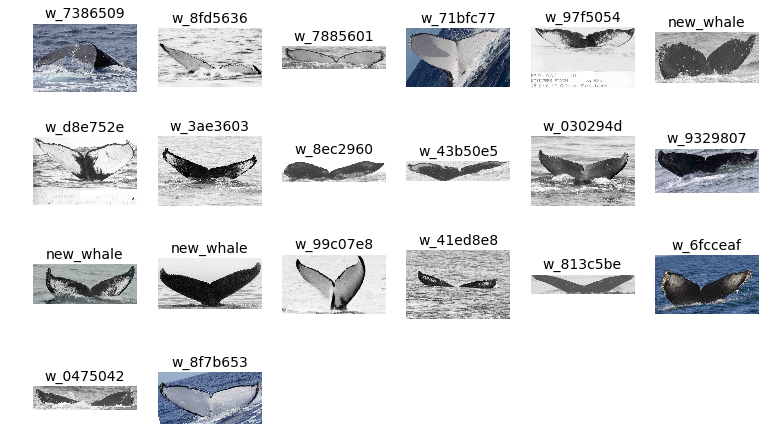

In [69]:
rand_rows = train_df.sample(frac=1.)[ : 20]
imgs = list(rand_rows['Image'])
labels = list(rand_rows['Id'])

im_training_sample = plot_images_with_filename_training(imgs, labels)
im_training_sample

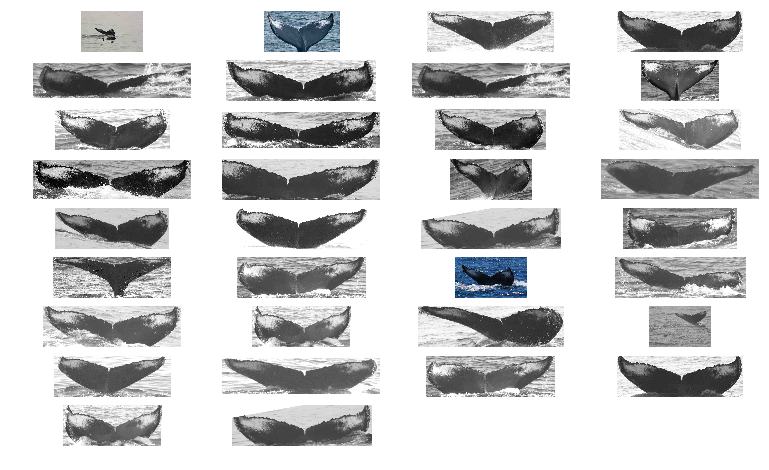

In [26]:
w_1287fbc = train_df[train_df['Id'] == 'w_1287fbc']
plot_images_for_filenames(list(w_1287fbc['Image']), None, rows=9)